---

<div align=center>

# **Initialisation**

</div>

### Dependencies

In [1]:
%%capture

import numpy as np
import tensorflow as tf
from LRFutils import archive, progress
import os
from multiprocess import Pool, cpu_count
import psutil
import pandas as pd
import matplotlib.pyplot as plt

2023-03-21 15:07:20.707316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 15:07:20.810732: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 15:07:23.067196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-21 15:07:23.067291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

### Configuration

In [2]:
valid_frac = 0.2
test_frac  = 0.1
dataset_path = "data/dataset"

### Global variables

In [3]:
archive_path = archive.new()

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

### Useful functions

In [4]:
def system_info():
    return f"CPU: {psutil.cpu_percent()}%"\
        + f", RAM: {psutil.virtual_memory().percent}%"\
        + f" ({psutil.virtual_memory().used/1024**3:.2f}GB"\
        + f"/ {psutil.virtual_memory().total/1024**3:.2f}GB)"

---

<div align=center>

# **Load data**

</div>

### Data properties

In [5]:
def data_labels(x,y):
    """Take a vector of a dataset and return it's properties"""

    x_labels = [
        # "Dust Obs. Wavelenght [um]",
        # "Dust Map",
        # "CO Velocity",
        "CO Cube",
        # "N2H+ Velocity",
        # "N2H Cube"
    ]
    
    y_labels = ["Mass"]

    return x_labels, y_labels

### Read one file

In [6]:
def load_file(file):

    data = np.load(file)

    CO_cube = data["CO_cube"]
    CO_map = np.sum(CO_cube, axis=-1)
    CO_map.reshape(*CO_map.shape, 1)

    x = [
        CO_map,
        # np.array(250), # dust observation frequency [um}
        # data["dust_image"].reshape(*data["dust_image"].shape, 1), # adding a channel dimension
        # data["CO_v"],
        # data["CO_cube"].reshape(*data["CO_cube"].shape, 1), # adding a channel dimension
        # data["N2H_v"],
        # data["N2H_cube"].reshape(*data["N2H_cube"].shape, 1) # adding a channel dimension
    ]
    
    y = [np.array(data["mass"])]

    return x, y

### Load data

In [7]:
def load_data() -> tuple[np.ndarray, tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Do what you want int this function, as long as it returns the following:
    - list[3D-ndarray] : input vectors
    - list[3D-ndarray] : output vectors
    """

    # Limit of the number of vectors to load
    max_files = 1000
    files = os.listdir(dataset_path)
    nb_vectors = min(len(files), max_files)

    # Load data
    x = []
    y = []
    bar = progress.Bar(nb_vectors, "Loading data")
    for i, file in enumerate(files):
        if i >= nb_vectors:
            break
        bar(i, prefix=system_info())
        
        new_x, new_y = load_file(f"{dataset_path}/{file}")
        x.append(new_x)
        y.append(new_y)
        
    bar(nb_vectors)    
    return x, y

In [8]:
x, y = load_data()
x_labels, y_labels = data_labels(x[0], y[0])
nb_vectors = len(x)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:00:066 eta 0:00:00


In [9]:
# fig, axs = plt.subplots(10, 4, figsize=(15, 15))

# for i in range(10):
#     vec = np.random.randint(0, len(x)+1)
#     print("----------")
#     print(len(x))
#     print(vec)
#     print(len(x[vec]))
#     axs[i, 0].imshow(x[vec][1])
#     axs[i, 1].plot(x[vec][2], label=r"CO $\nu$")
#     axs[i, 1].plot(x[vec][4], label=r"N2H+ $\nu$")
#     axs[i, 1].legend()
#     axs[i, 2].imshow(np.sum(x[vec][3], axis=(-1,-2)))
#     axs[i, 3].imshow(np.sum(x[vec][5], axis=(-1,-2)))

---

<div align=center>

# **Post processing**

</div>

### Normalisation

In [10]:
x_maxs = []
for element in x[0]:
    x_maxs.append(element.ravel()[0])

y_maxs = []
for element in y[0]:
    y_maxs.append(element.ravel()[0])

for vector in x:
    for i in range(len(vector)):
        if (value := np.max(np.abs(vector[i]))) > x_maxs[i]:
            x_maxs[i] = value

for i in range(len(x)):
    for j in range(len(vector)):
        x[i][j] /= x_maxs[j]

for vector in y:
    for i in range(len(vector)):
        if (value := np.max(np.abs(vector[i]))) > y_maxs[i]:
            y_maxs[i] = value

for i in range(len(y)):
    for j in range(len(vector)):
        y[i][j] /= y_maxs[j]

df = pd.DataFrame(np.matrix(x_maxs + y_maxs))
df.columns = x_labels + y_labels
df

,CO Cube,Mass
0,372.276093,5.598523e+08


### Splitting datasets
#### Train

In [11]:
train_frac = 1 - valid_frac - test_frac

train_x = x[:int(nb_vectors * train_frac)]
train_y = y[:int(nb_vectors * train_frac)]

df = pd.DataFrame(train_x)
df.columns = x_labels
df

,CO Cube
0,"[[0.0914135, 0.0966694, 0.10216966, 0.10791366..."
1,"[[0.04898308, 0.05212534, 0.05544892, 0.058958..."
2,"[[0.82650846, 0.8318724, 0.83714265, 0.8423086..."
3,"[[0.8409719, 0.84497446, 0.8489109, 0.8527756,..."
4,"[[0.85229665, 0.8553014, 0.85824925, 0.8611362..."
...,...
695,"[[0.034511548, 0.03743358, 0.04058741, 0.04398..."
696,"[[0.9308385, 0.93409264, 0.9372474, 0.9402998,..."
697,"[[0.9705977, 0.9718896, 0.9731375, 0.97434187,..."
698,"[[0.8755546, 0.8795303, 0.8834299, 0.8872496, ..."


In [12]:
df = pd.DataFrame(train_y)
df.columns = y_labels
df

,Mass
0,0.003855349343635972
1,0.003354121881931433
2,0.30960561270137427
3,0.18606053783945395
4,0.1034588720935196
...,...
695,0.0067555262027187936
696,0.6840337893816515
697,0.7428624230238865
698,0.3660914113231722


#### Validation

In [13]:
valid_x = x[int(nb_vectors * train_frac):int(nb_vectors * (train_frac + valid_frac))]
valid_y = y[int(nb_vectors * train_frac):int(nb_vectors * (train_frac + valid_frac))]

df = pd.DataFrame(valid_x)
df.columns = x_labels
df

,CO Cube
0,"[[0.27161324, 0.28217605, 0.29272145, 0.303210..."
1,"[[0.8828616, 0.8856044, 0.8883036, 0.89095706,..."
2,"[[0.9451641, 0.9477509, 0.9502505, 0.9526616, ..."
3,"[[0.85931253, 0.8623292, 0.86529803, 0.8682157..."
4,"[[-2.499575e-06, -2.713807e-06, -2.9596652e-06..."
...,...
195,"[[0.017843539, 0.019148376, 0.020542923, 0.022..."
196,"[[0.74062616, 0.74711704, 0.7535139, 0.7597956..."
197,"[[-2.767921e-10, -3.0209302e-10, -3.3105318e-1..."
198,"[[0.9573648, 0.95921147, 0.96099967, 0.9627284..."


In [14]:
df = pd.DataFrame(train_y)
df.columns = y_labels
df

,Mass
0,0.003855349343635972
1,0.003354121881931433
2,0.30960561270137427
3,0.18606053783945395
4,0.1034588720935196
...,...
695,0.0067555262027187936
696,0.6840337893816515
697,0.7428624230238865
698,0.3660914113231722


#### Test

In [15]:
test_x = x[int(nb_vectors * (train_frac + valid_frac)):]
test_y = y[int(nb_vectors * (train_frac + valid_frac)):]

df = pd.DataFrame(test_x)
df.columns = x_labels
df

,CO Cube
0,"[[0.92116934, 0.92436624, 0.9274815, 0.9305121..."
1,"[[0.0022281648, 0.0024754142, 0.0027425776, 0...."
2,"[[0.89007366, 0.8926114, 0.89510614, 0.8975566..."
3,"[[-1.8019401e-07, -1.9822217e-07, -2.1837499e-..."
4,"[[0.84403354, 0.8483486, 0.8525768, 0.85671186..."
...,...
95,"[[0.7686266, 0.7748975, 0.7810669, 0.7871165, ..."
96,"[[0.6131354, 0.61991125, 0.62659305, 0.6331582..."
97,"[[0.9370242, 0.94015706, 0.94318914, 0.9461168..."
98,"[[0.9629865, 0.9644797, 0.96592635, 0.9673239,..."


In [16]:
df = pd.DataFrame(train_y)
df.columns = y_labels
df

,Mass
0,0.003855349343635972
1,0.003354121881931433
2,0.30960561270137427
3,0.18606053783945395
4,0.1034588720935196
...,...
695,0.0067555262027187936
696,0.6840337893816515
697,0.7428624230238865
698,0.3660914113231722


---

<div align=center>

# **Model definition**

</div>

### Build model

In [17]:
def get_model(input_shapes, output_shapes):
    from keras.layers import Input, Dense, Conv2D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Reshape, Conv3DTranspose, Flatten
    from keras.models import Model

    # Définir la forme de l'image d'entrée
    input = Input(shape=input_shapes[0])

    # Encoder
    # x = Conv2D(8, (5, 5), activation='relu', padding='same')(input)
    # x = MaxPooling2D((4, 4), padding='same')(x)
    # x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D((4, 4), padding='same')(x)
    # x = Flatten()(x)
    # x = Dense(1024, activation='relu')(x)
    x = Dense(128, activation='relu')(input)
    output = Dense(1, activation='relu')(x)

    # Modèle d'auto-encodeur
    model = Model(input, output)

    return model

### Compile model and get summary

In [18]:
x_shapes = [x[0][i].shape for i in range(len(x[0]))]
y_shapes = [y[0][i].shape for i in range(len(y[0]))]

model = get_model(x_shapes, y_shapes)
# model.compile(optimizer='adam', loss='binary_crossentropy')
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64)]          0         
                                                                 
 dense (Dense)               (None, 64, 128)           8320      
                                                                 
 dense_1 (Dense)             (None, 64, 1)             129       
                                                                 
Total params: 8,449
Trainable params: 8,449
Non-trainable params: 0
_________________________________________________________________


2023-03-21 15:07:37.192985: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-21 15:07:37.193017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-21 15:07:37.193571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Human validation of the model

In [19]:
choice = input("Continue ? [Y/n]")

if choice.lower() not in ["", "y", "yes"]:
    exit()

In [20]:
train_x = np.array([i[0] for i in train_x])
valid_x = np.array([i[0] for i in valid_x])
test_x = np.array([i[0] for i in test_x])

train_y = np.array([i[0] for i in train_y])
valid_y = np.array([i[0] for i in valid_y])
test_y = np.array([i[0] for i in test_y])

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(700, 64, 64) (700,)
(200, 64, 64) (200,)
(100, 64, 64) (100,)


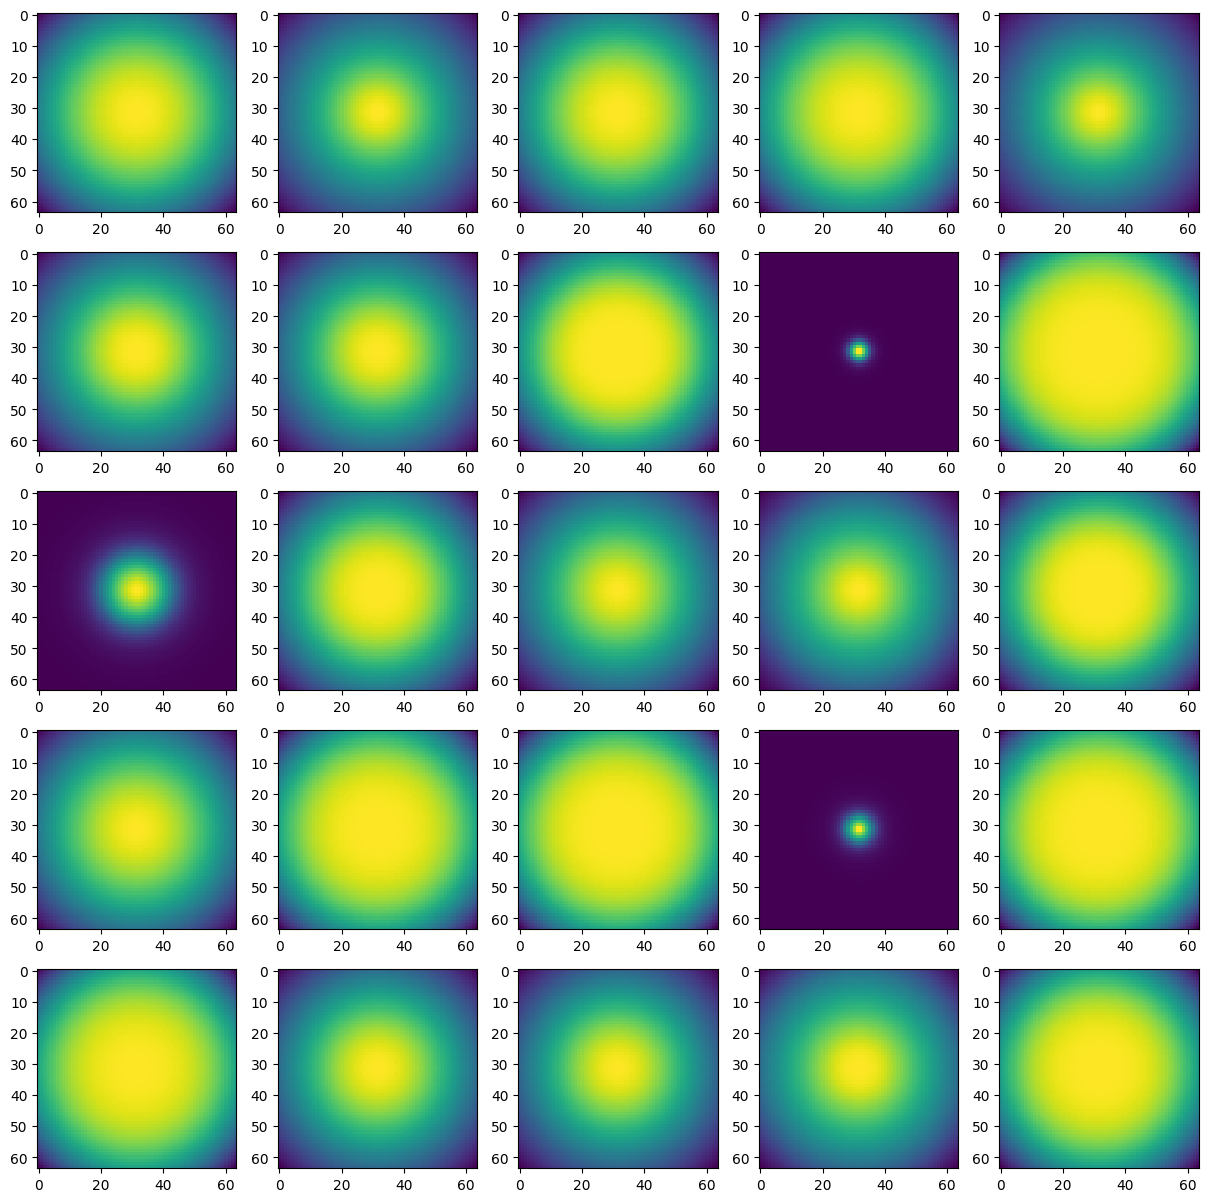

In [21]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        vec = np.random.randint(0, len(train_x)+1)
        axs[i, j].imshow(train_x[vec])

### Training model

In [22]:
model.fit(train_x, train_y, epochs=100, batch_size=1, validation_data=(valid_x, valid_y))
model.save(f'{archive_path}/model0.h5')

Epoch 1/100
700/700 [==============================] - 2s 2ms/step - loss: 0.0716 - accuracy: 0.0000e+00 - val_loss: 0.0792 - val_accuracy: 0.0000e+00
Epoch 2/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0716 - accuracy: 0.0000e+00 - val_loss: 0.0792 - val_accuracy: 0.0000e+00
Epoch 3/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0716 - accuracy: 0.0000e+00 - val_loss: 0.0792 - val_accuracy: 0.0000e+00
Epoch 4/100
700/700 [==============================] - 1s 2ms/step - loss: 0.0716 - accuracy: 0.0000e+00 - val_loss: 0.0792 - val_accuracy: 0.0000e+00
Epoch 5/100
700/700 [==============================] - 1s 2ms/step - loss: 0.0716 - accuracy: 0.0000e+00 - val_loss: 0.0792 - val_accuracy: 0.0000e+00
Epoch 6/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0716 - accuracy: 0.0000e+00 - val_loss: 0.0792 - val_accuracy: 0.0000e+00
Epoch 7/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0716 - accuracy: 

### Evaluating model

In [23]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Score:", score)

with open(f'{archive_path}/scores.txt', 'w') as f:
    f.write(f'Score:    \t{score}\n')

Score: [0.07789335399866104, 0.0]


---

<div align=center>

# **Predictions**

</div>

In [24]:
x_prediction = [x[0,...]]
x_prediction = np.expand_dims(x_prediction, axis=-1)
print(x_prediction.shape)

y_prediction = model.predict(x_prediction)
print(y_prediction.shape)

np.savez_compressed(f'{archive_path}/prediction.npz', x=x_prediction, y=y_prediction)

TypeError: list indices must be integers or slices, not tuple